<a href="https://colab.research.google.com/github/mohsenmolaei/seriesnet_based/blob/main/seriesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet"

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/15DygMAXOJIypb4JGFSiPmdC6GqJjdD9a/tripple stage seriesnet


In [ ]:
import pdb
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.feature_selection import mutual_info_classif
# !pip install yfinance
# import yfinance as yf
# !pip install lingam

import TSASeriesNet
# import feature_selection
if torch.cuda.is_available():
    # dev = "TPU:0"
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(device)

cuda:0


In [ ]:
data= pd.read_csv('data.csv')
data.set_index("time_stamp",inplace=True,drop=True)
# data
# label_encoder = LabelEncoder()
# n_bins = 50
# data['difficulty_latest'] = data['difficulty_latest'].astype(float)
# data['hash_rate_mean'] = data['hash_rate_mean'].astype(float)

# data['difficulty_latest'] = label_encoder.fit_transform(pd.cut(data['difficulty_latest'] , n_bins, retbins=True)[0])
# data['hash_rate_mean'] = label_encoder.fit_transform(pd.cut(data['hash_rate_mean'], n_bins, retbins=True)[0])

# whatcol=[ 'price_drawdown_relative','difficulty_latest',
#            'hash_rate_mean', 'active_more_1y_percent', 'utxo_created_value_median', 
#            'transfers_volume_median', 'utxo_spent_value_median']

X, Y = data.drop(["price_usd_close"],axis =1), np.array(data.price_usd_close) #data[whatcol]
# X.shape

In [ ]:
# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(X, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = col
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

# # xindex = mi.sort_values(ascending=False)[0:8]
# # X = data[xindex.index]


In [ ]:
data_top15= pd.read_csv('top15.csv')
data_top15.set_index("time_stamp",inplace=True,drop=True)

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data_top15)

# label_encoder = LabelEncoder()
# n_bins = 50

# mi15= pd.DataFrame()
# mi15 = mutual_info_classif(data_top15, y_train)#, discrete_features=discrete_vars)
# mi15 = pd.Series(mi15)

# mi15.index = data_top15.columns
# mi15.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

In [ ]:
# ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']

Condition= pd.read_csv('Condition.csv')
Condition.set_index("time_stamp",inplace=True,drop=True)
# Condition

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(Condition)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(Condition, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = Condition.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")
# plt.show()

# xindex = mi.sort_values(ascending=False)[0:8]
# Condition = data[xindex.index]

# Condition.columns

In [ ]:
col = list(data.columns)+ list(Condition.columns)+list(data_top15.columns)
cond = pd.DataFrame(np.hstack((data , Condition)))
cond = pd.DataFrame(np.hstack((cond,data_top15)))
cond.columns =col

# import importlib
# importlib.reload(feature_selection)

# crypto = "price_usd_close"
# selectmx , matrix_correlation , matrix_observed , matrix_latent , matrix_granger , matrix_mi = feature_selection.select_matrix(cond, crypto)
# cond =cond.drop(["price_usd_close"],axis =1)


# selectmx.to_csv("select_matrix.csv")

# matrix_correlation.to_csv("matrix_correlation.csv")
# matrix_observed.to_csv("matrix_observed.csv")
# matrix_latent.to_csv("matrix_latent.csv")
# matrix_granger.to_csv("matrix_granger.csv")
# matrix_mi.to_csv("matrix_mi.csv")


**TEST data**

In [ ]:
test_data= pd.read_csv('test_data.csv')
# test_data.set_index("time_stamp",inplace=True,drop=True)

xtest = test_data.price_usd_close
condtest = test_data[["receiving_count", "^DJI"]]
ytest = test_data.price_usd_close


,receiving_count,^DJI
0,741495,33601.148438
1,674908,33601.148438
2,693763,33601.148438
3,836261,33402.378906
4,756577,33482.718750
5,818121,33485.289062
6,762477,33485.289062
7,672298,33586.519531
8,580309,33586.519531
9,635975,33586.519531


In [ ]:
"""# scale features""" 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MMScaler = MinMaxScaler()
SScaler = StandardScaler()
condscaler = StandardScaler()

MMScaler_test = MinMaxScaler()
SScaler_test = StandardScaler()
condscaler_test = StandardScaler()

X_trans_test = SScaler_test.fit_transform(xtest.values.reshape(-1, 1))
c_trans_test = condscaler_test.fit_transform(condtest)
y_trans_test = MMScaler_test.fit_transform(ytest.values.reshape(-1, 1))


XX = np.array(data.price_usd_close)
X_trans = SScaler.fit_transform(XX.reshape(-1, 1))#Y.reshape(-1, 1))
condtemp = cond
c_trans = condscaler.fit_transform(condtemp[["receiving_count", "^DJI"]])

# for i in range(0,len(selectmx.T)):
#   col2 = c_trans[:,i].copy()
#   if selectmx.T["price_usd_close"][i] >= max(selectmx.T["price_usd_close"]) :
#     print(col[i])
#     col2 *= selectmx.T["price_usd_close"][i]/max(selectmx.T["price_usd_close"])
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")
# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col.all() == 0)], axis=1)

y_trans = MMScaler.fit_transform(Y.reshape(-1, 1))
print(X_trans.shape)
print(c_trans.shape)
print(y_trans.shape)

"""# split a multivariate sequence past, future samples (X and y)"""
def split_sequences(input_sequences, condition_seq, output_sequence, n_steps_in, n_steps_out):
    X, C, y = list(),list(), list() 
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out 
        if out_end_ix >= len(input_sequences): break
        seq_x, seq_c, seq_y = input_sequences[i:end_ix], condition_seq[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), C.append(seq_c) ,y.append(seq_y)
    return np.array(X), np.array(C), np.array(y)

x_shape = 30
y_shape = 7
# Train data
X_ss, C_ss, y_mm = split_sequences(X_trans, c_trans, y_trans, x_shape, y_shape)
print(X_ss.shape, C_ss.shape, y_mm.shape)

#Test data
DataX_test, DataC_test, Datay_test = split_sequences(X_trans_test, c_trans_test, y_trans_test, x_shape, y_shape)

# print(X_trans_test[-37:-7])
# print(X_trans_test[-7:])

total_samples = len(X)
train_test_cutoff = round(0.80 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff)]
C_train = C_ss[:-(total_samples-train_test_cutoff)]
X_test = X_ss[-(total_samples-train_test_cutoff):]
C_test = C_ss[-(total_samples-train_test_cutoff):]

y_train = y_mm[:-(total_samples-train_test_cutoff)]
y_test = y_mm[-(total_samples-train_test_cutoff):] 

# Randomly shuffle the indices
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# Reorder the data using the shuffled indices
X_train_shuffled = X_train[indices]
C_train_shuffled = C_train[indices]
y_train_shuffled = y_train[indices]


print(total_samples - train_test_cutoff)
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

"""# convert to pytorch tensors"""
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

C_train_tensors = Variable(torch.Tensor(C_train).to(device))
C_test_tensors = Variable(torch.Tensor(C_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

print(X_train_tensors.shape)
print(C_train_tensors.shape)

# DataX_test, DataC_test, Datay_test
DataX_test = Variable(torch.Tensor(DataX_test).to(device))
DataC_test = Variable(torch.Tensor(DataC_test).to(device))
Datay_test = Variable(torch.Tensor(Datay_test).to(device))

"""# reshaping to rows, timestamps, features"""

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], x_shape, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], x_shape, 
                                      X_test_tensors.shape[2])) 

C_train_tensors_final = torch.reshape(C_train_tensors,   
                                      (C_train_tensors.shape[0], x_shape, 
                                       C_train_tensors.shape[2]))
C_test_tensors_final = torch.reshape(C_test_tensors,  
                                     (C_test_tensors.shape[0], x_shape, 
                                      C_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, C_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, C_test_tensors_final.shape, y_test_tensors.shape)


(2643, 1)
(2643, 2)
(2643, 1)
(2606, 30, 1) (2606, 30, 2) (2606, 7, 1)
529
Training Shape: (2077, 30, 1) (2077, 7, 1)
Testing Shape: (529, 30, 1) (529, 7, 1)
torch.Size([2077, 30, 1])
torch.Size([2077, 30, 2])
Training Shape: torch.Size([2077, 30, 1]) torch.Size([2077, 30, 2]) torch.Size([2077, 7, 1])
Testing Shape: torch.Size([529, 30, 1]) torch.Size([529, 30, 2]) torch.Size([529, 7, 1])


In [ ]:
# %%
def NRMSELoss(yhat,y): #NRMSE
  y = y.reshape(y.shape[0], y.shape[1])
  return (torch.sqrt(torch.mean(torch.square(yhat-y))))/ (torch.max(y) - torch.min(y))

# Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_pred,y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

def MAPELoss(yhat,y):
  y = y.reshape(y.shape[0], y.shape[1])
  return torch.mean(torch.abs(yhat-y)/torch.abs(y))

def SMAPELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = 2 * torch.mean(torch.abs(y_true - y_pred) / (torch.max(y_true) + torch.max(y_true)))
  return loss

def MSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.mean((y_pred - y_true)**2)
  return loss

def RMSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.sqrt(torch.mean((y_pred - y_true)**2))
  return loss

In [ ]:
# !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs')


def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=200):
    lr = init_lr * (0.9**(epoch // lr_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def training_loop(n_epochs,learning_rate, lr_decay_epoch, network, optimiser, loss_fn, X_train, Condition_train, y_train,X_test, Condition_test, y_test):
    loss_valid_show,loss_train_show = [],[]

    if torch.cuda.is_available():
        network.cuda()
    best_valid_loss = float('inf')
    best_epoch = -1
    
    for epoch in range(n_epochs):
        if (epoch % (lr_decay_epoch) == 0) and (epoch != 0):
            optimiser = exp_lr_scheduler(optimiser,epoch, init_lr= learning_rate , lr_decay_epoch= lr_decay_epoch)

        network.train()
        outputs = network.forward(X_train, Condition_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        
        # pdb.set_trace()
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        # print(optimiser.lr)

        optimiser.step() # improve from loss, i.e backprop
        # test loss
        network.eval()
        test_preds = network(X_test, Condition_test)
        test_loss = loss_fn(test_preds, y_test)

        loss_valid_show.append(test_loss.item())
        loss_train_show.append(loss.item())

        # writer.add_scalar('Accuracy/train', acc, epoch)
        writer.add_scalar('Loss/Validation', test_loss.item(), epoch)
        writer.add_scalar('Loss/Train', loss.item(), epoch)

        # Save model weights if validation loss improves
        if test_loss < best_valid_loss:
            best_valid_loss = test_loss
            best_epoch = epoch
            torch.save({'epoch': epoch, 'state_dict': network.state_dict()}, f'./weights/model_epoch_{epoch}.pth')


        if (epoch) % (20) == 0:
            print("Epoch: %4d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(),test_loss.item()))
    writer.close()
    return loss_train_show , loss_valid_show , best_valid_loss , best_epoch


In [ ]:
"""# Training"""

import torch
import gc
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

124

In [ ]:
# torch.manual_seed(17)
# torch.cuda.manual_seed(17)
# np.random.seed(17)
# torch.backends.cudnn.deterministic=True

import importlib
import Decoder_DARLM
import Encoder_DARLM
import ts_lstm
import ts_gru
import HSAM
import CBAM

importlib.reload(CBAM)
importlib.reload(Decoder_DARLM)
importlib.reload(TSASeriesNet)
importlib.reload(Encoder_DARLM)
importlib.reload(ts_lstm)
importlib.reload(ts_gru)
importlib.reload(HSAM)

n_epochs = 201
num_inputs = X_train_tensors_final.shape[1] 
dilation_c = 2
kernel_size_EN = 3
kernel_size_DE = 3
hidden_size_lstm =20

num_levels_en = 6
num_levels_de = 4
num_layers_lstm = 3
num_layers_gru = 3
features = X_train_tensors_final.shape[2]   
features_c = C_train_tensors_final.shape[2] 
output_num = y_train_tensors.shape[1]

lr_decay_epoch = 49
learning_rate = 0.01
weight_decay = 0.0001

loss_fn = RMSELoss #SMAPELoss #MAPELoss #NRMSELoss #rmspe #RMSELoss
# ANN model 
myModel = TSASeriesNet.ANNmodel(num_inputs, features_c, features, output_num, num_levels_en,num_levels_de, kernel_size_EN, kernel_size_DE, dilation_c, hidden_size_lstm, num_layers_lstm, num_layers_gru ).to(device)
optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=weight_decay)#,eps=1e-08)#, lr=learning_rate)#, eps=1e-08)#

loss_train_show ,loss_valid_show , best_valid_loss , best_epoch= training_loop(n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors)

print(f"best validation loss: {best_valid_loss} in epoch {best_epoch}")


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch:    0, train loss: 0.27903, test loss: 0.48661
Epoch:   20, train loss: 0.21201, test loss: 0.35636
Epoch:   40, train loss: 0.12054, test loss: 0.25700
Epoch:   60, train loss: 0.11133, test loss: 0.10165
Epoch:   80, train loss: 0.04242, test loss: 0.04241
Epoch:  100, train loss: 0.03733, test loss: 0.03653
Epoch:  120, train loss: 0.03162, test loss: 0.03589
Epoch:  140, train loss: 0.03306, test loss: 0.03531
Epoch:  160, train loss: 0.02993, test loss: 0.03514
Epoch:  180, train loss: 0.03161, test loss: 0.03524
Epoch:  200, train loss: 0.02891, test loss: 0.03466
best validation loss: 0.034462761133909225 in epoch 185


Back Test

In [ ]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])
# DataX_test, DataC_test, Datay_test

predict = myModel(DataX_test,DataC_test)
predict = predict.detach().cpu().numpy()
predict = MMScaler_test.inverse_transform(predict)
# predict = predict[-100:]
true = np.squeeze(Datay_test)
true = MMScaler_test.inverse_transform(true.cpu())
# true = true[-100:]

# calculate the daily returns based on the predicted and true prices
predict_returns = (predict[:, 1:] - predict[:, :-1]) / predict[:, :-1]
true_returns = (true[:, 1:] - true[:, :-1]) / true[:, :-1]

# calculate the position you would have taken based on your prediction
threshold = 0.00001  # 1% return threshold
predict_position = np.where(predict_returns > threshold, 1, -1)
true_position = np.where(true_returns > threshold, 1, -1)

# define a function to simulate the portfolio based on the predicted or true returns
def simulate_portfolio(position, returns, initial_capital):
    # calculate the daily profit and loss based on the position you took and the daily returns
    transaction_cost = 0.001  # 0.1% per transaction
    position_percentage = 0.2  # 10% of capital
    pnl = position * (initial_capital * position_percentage) * (returns - transaction_cost)

    # calculate the cumulative PnL over the entire period
    cumulative_pnl = np.cumsum(pnl)

    # calculate the final portfolio value
    final_value = initial_capital + cumulative_pnl[-1]

    # calculate the profit percentage
    profit_percentage = ((final_value - initial_capital) / initial_capital) * 100

    return final_value, profit_percentage

# simulate the portfolio based on the predicted and true returns for different initial capital values
for cap in [1000, 2000, 5000, 10000]:
    print(f"\nFor initial capital of {cap}:")
    predict_final_value, predict_profit_percentage = simulate_portfolio(predict_position, predict_returns, cap)
    true_final_value, true_profit_percentage = simulate_portfolio(true_position, true_returns, cap)
    print(f"Predicted final value   : {predict_final_value:.2f} with {predict_profit_percentage:.2f}% profit")
    print(f"True final value        : {true_final_value:.2f} with {true_profit_percentage:.2f}% profit")
    print(f"(Predicted/True)% profit: {predict_final_value*100/true_final_value:.2f}% profit") 
    print("-----------------------------------------------------------")


For initial capital of 1000:
Predicted final value   : 999.53 with -0.05% profit
True final value        : 1040.95 with 4.09% profit
(Predicted/True)% profit: 96.02% profit
-----------------------------------------------------------

For initial capital of 2000:
Predicted final value   : 1999.05 with -0.05% profit
True final value        : 2081.90 with 4.09% profit
(Predicted/True)% profit: 96.02% profit
-----------------------------------------------------------

For initial capital of 5000:
Predicted final value   : 4997.63 with -0.05% profit
True final value        : 5204.74 with 4.09% profit
(Predicted/True)% profit: 96.02% profit
-----------------------------------------------------------

For initial capital of 10000:
Predicted final value   : 9995.26 with -0.05% profit
True final value        : 10409.48 with 4.09% profit
(Predicted/True)% profit: 96.02% profit
-----------------------------------------------------------


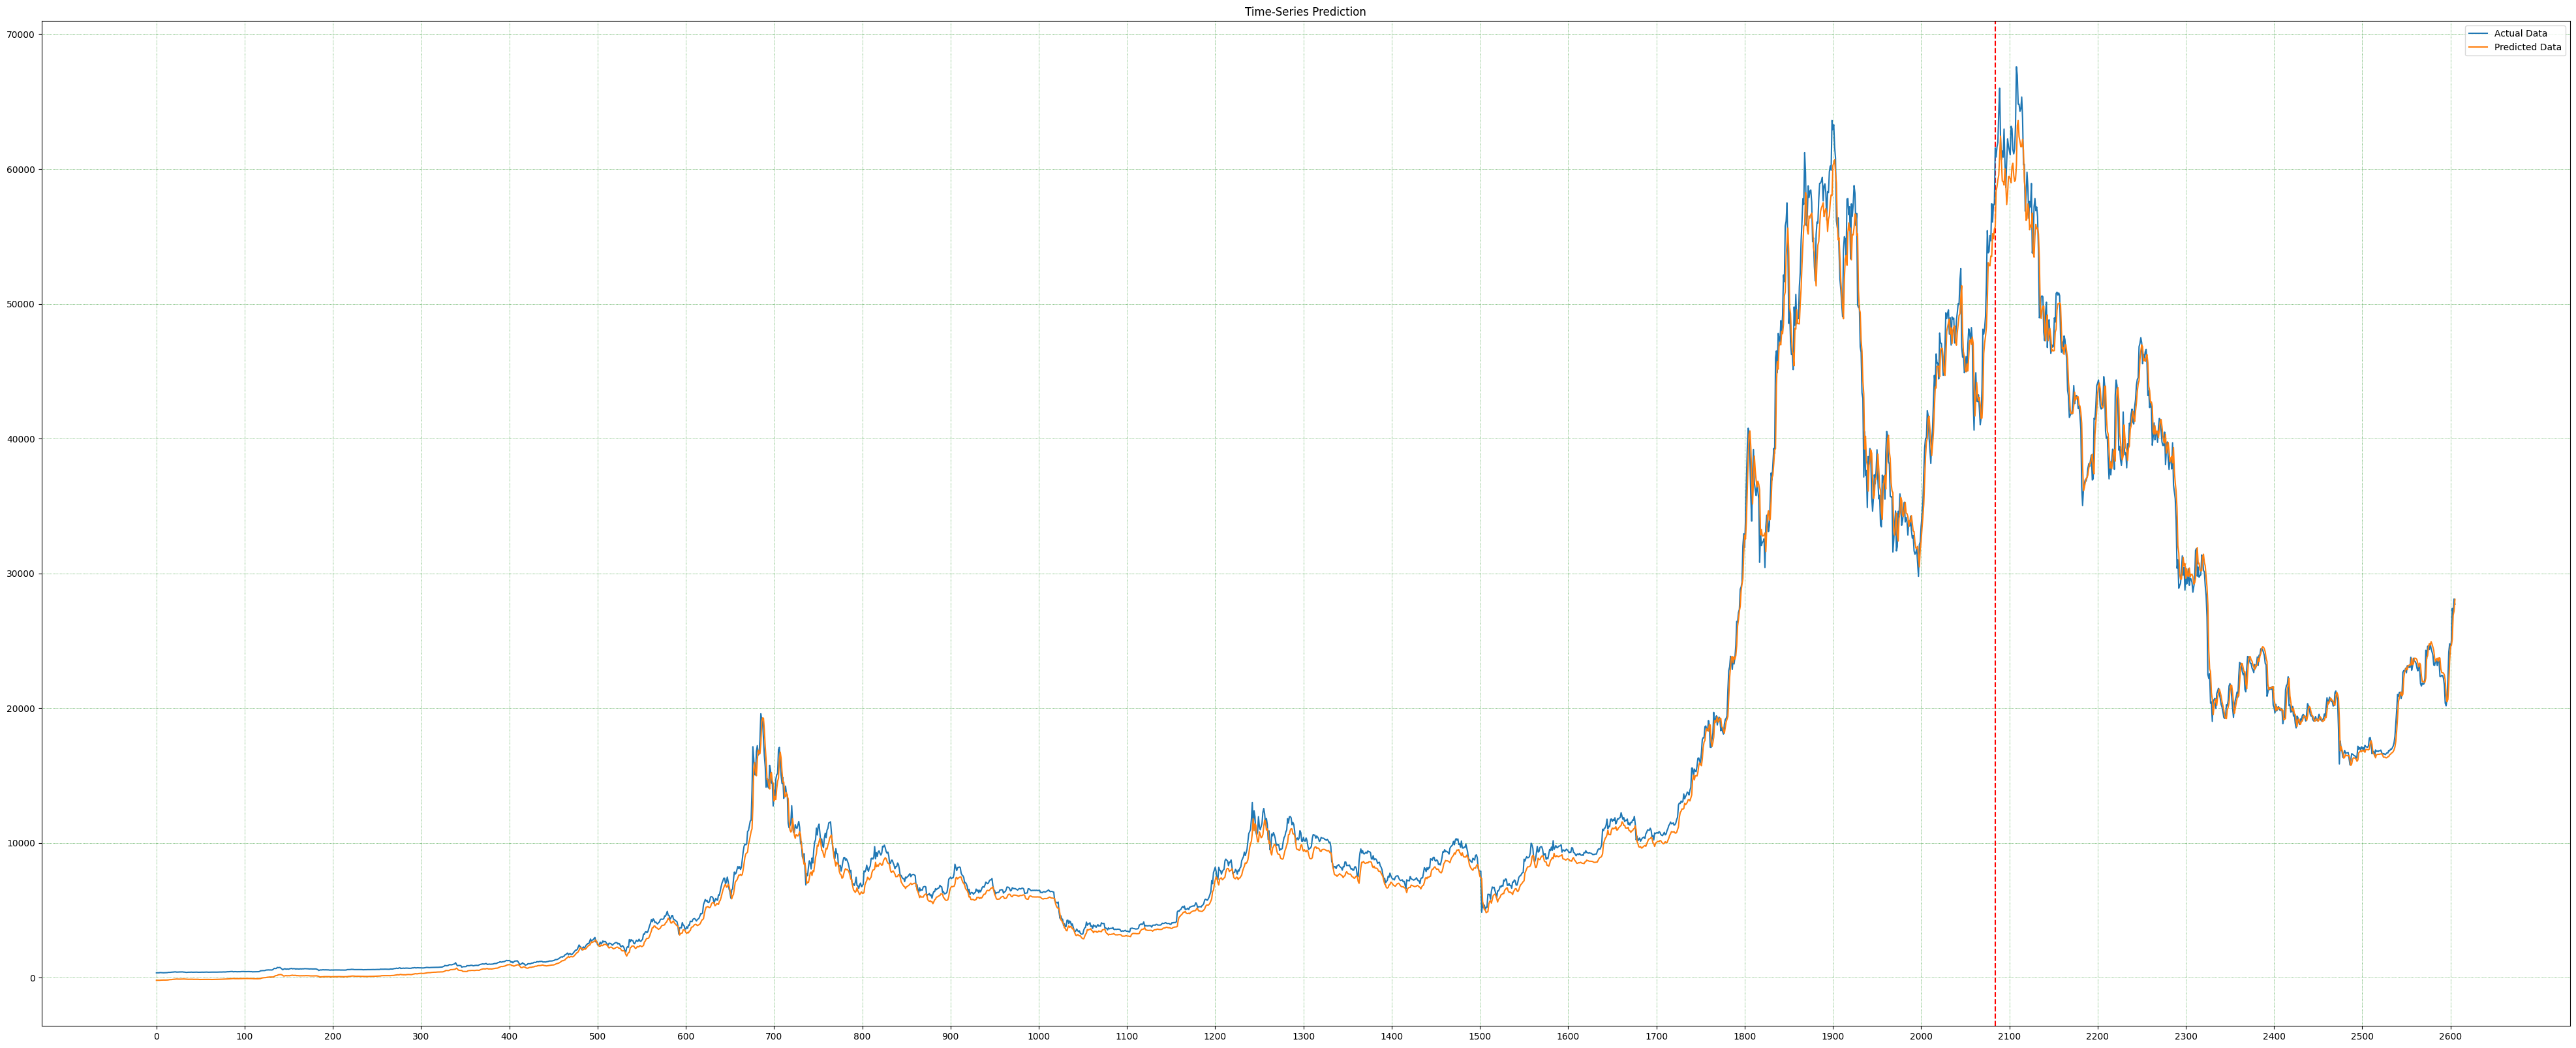

In [ ]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])


df_X_ss = SScaler.transform(XX.reshape(-1, 1)) # old transformers
# df_C_ss = condscaler.transform(condtemp[["utxo_spent_value_median", "receiving_count","active_count", "volume_median",
#                                             "difficulty_latest", "SI=F", "^DJI", "^IXIC", "N225", "AVAX-USD", "BNB-USD",
#                                             "DOGE-USD", "LTC-USD", "SHIB-USD", "SOL-USD", "USDC-USD"]])
df_C_ss = condscaler.transform(condtemp[["receiving_count", "^DJI"]])

# for i in range(0,len(selectmx.T)):
#   col2 = df_C_ss[:,i].copy()
#   col2 *= selectmx.T["price_usd_close"][i]/max(selectmx.T["price_usd_close"])-2
#   df_C_ss[:, i] = col2

# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col.all() == 0)], axis=1)

df_y_mm = MMScaler.transform(np.array(data.price_usd_close).reshape(-1, 1))
df_y_mm = df_y_mm.squeeze()
# split the sequence
df_X_ss, df_C_ss, df_y_mm = split_sequences(df_X_ss, df_C_ss, df_y_mm, x_shape, y_shape)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_C_ss = Variable(torch.Tensor(df_C_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], x_shape, df_X_ss.shape[2]))
df_C_ss = torch.reshape(df_C_ss, (df_C_ss.shape[0], x_shape, df_C_ss.shape[2]))

train_predict = myModel(df_X_ss.to(device),df_C_ss.to(device)).cpu() # forward pass

data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = MMScaler.inverse_transform(data_predict) # reverse transformation
dataY_plot = dataY_plot.squeeze()
dataY_plot = MMScaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(50,20)) #plotting
plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

plt.xticks(range(0,total_samples,100))
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

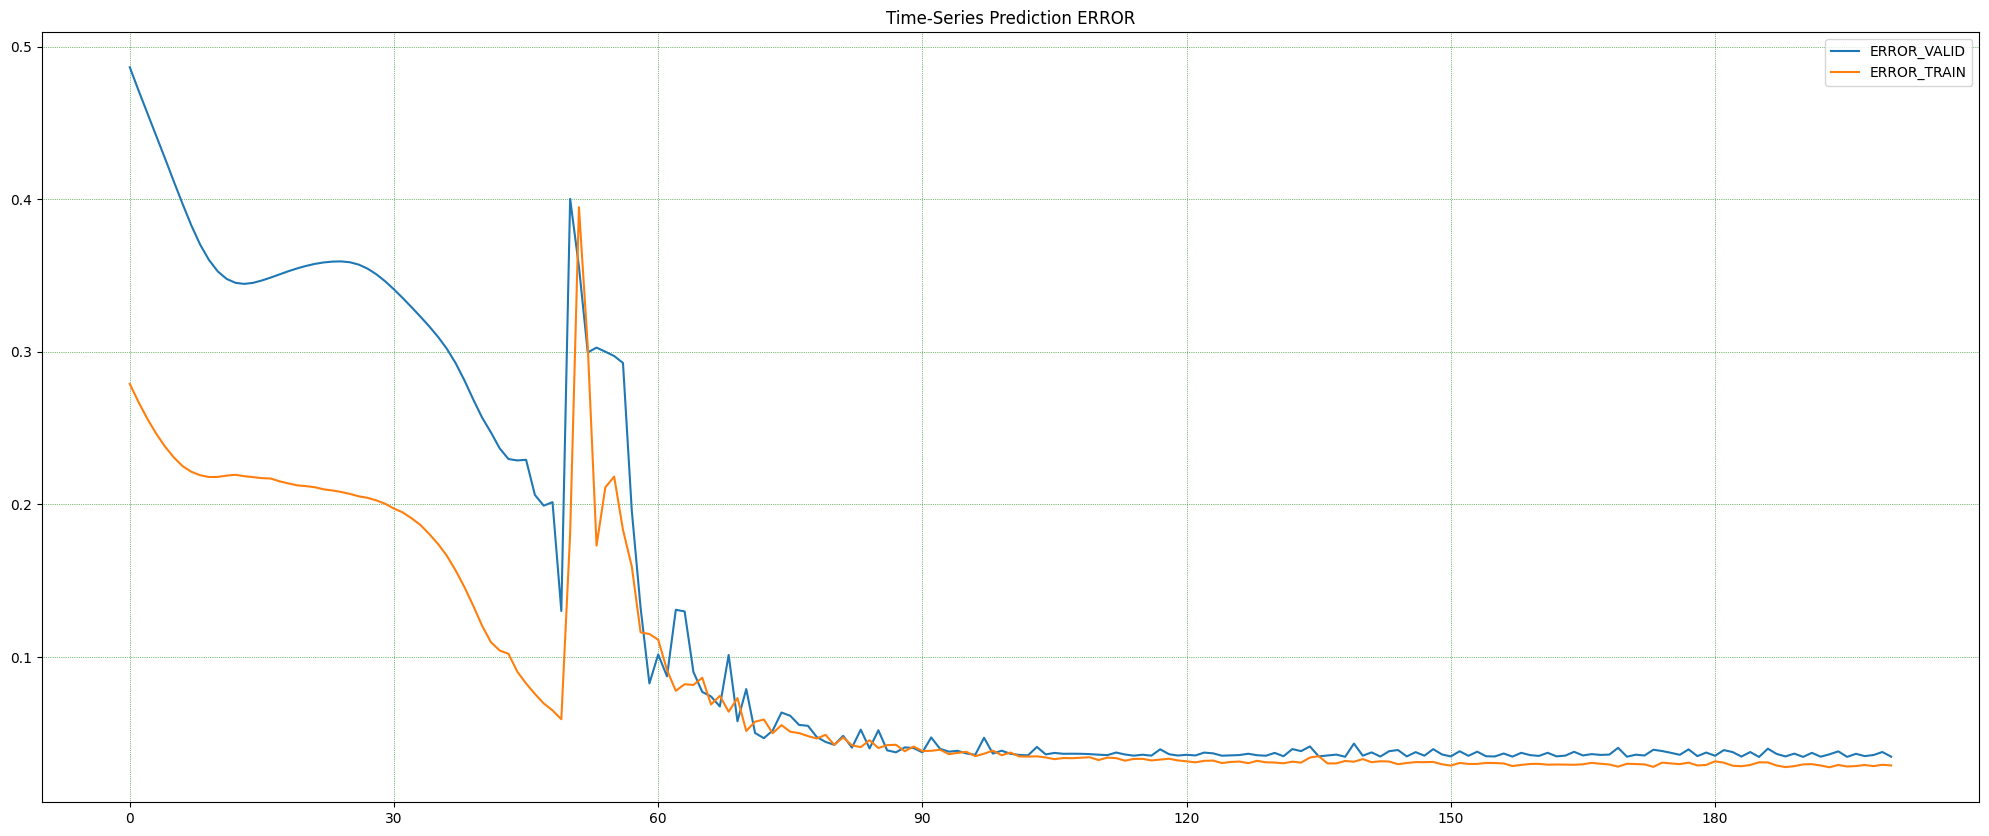

In [ ]:
plt.figure(figsize=(25,10)) #plotting
plt.plot(loss_valid_show, label='ERROR_VALID') 
plt.plot(loss_train_show, label='ERROR_TRAIN') 
plt.title('Time-Series Prediction ERROR')
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.xticks(range(0,n_epochs+1,30))
plt.legend()
plt.show()
# print(loss_show)


In [ ]:
# myModel
# # Print initial weights
# print("Initial weights:")
# for name, param in myModel.named_parameters():
#     if 'weight' in name:
#         print(name, param.data)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/logs

In [ ]:
# from sklearn.model_selection import ParameterGrid

# # Define the hyperparameter grid
# param_grid = {
#     'kernel_size_EN': [2,3],
#     'kernel_size_DE': [2,3],
#     'hidden_size_lstm': [20],
#     'num_levels_en': [2,4,6],
#     'num_levels_de': [2,4,6],
#     'num_layers_lstm': [6],
#     'num_layers_gru': [4]
# }
# loss_fn = NRMSELoss
# lr_decay_epoch = 49
# learning_rate = 0.01
# weight_decay = 0.001

# def run_experiment(params):
#     myModel = TSASeriesNet.ANNmodel(X_train_tensors_final.shape[1], C_train_tensors_final.shape[2], X_train_tensors_final.shape[2],y_train_tensors.shape[1],
#                                     params['num_levels_en'], params['num_levels_de'], params['kernel_size_EN'],
#                                     params['kernel_size_DE'], 2, params['hidden_size_lstm'],
#                                     params['num_layers_lstm'], params['num_layers_gru']).to(device)

#     optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=0.0001)#, weight_decay=weight_decay, lr=learning_rate)

#     loss_train_show, loss_valid_show = training_loop(n_epochs=401,
#                                                       learning_rate=learning_rate,
#                                                       lr_decay_epoch=lr_decay_epoch,
#                                                       network=myModel,
#                                                       optimiser=optimiser,
#                                                       loss_fn= loss_fn,
#                                                       X_train=X_train_tensors_final,
#                                                       Condition_train=C_train_tensors_final,
#                                                       y_train=y_train_tensors,
#                                                       X_test=X_test_tensors_final,
#                                                       Condition_test=C_test_tensors_final,
#                                                       y_test=y_test_tensors)
#     return loss_valid_show[-1]

# import itertools

# def grid_search(param_grid):
#     keys, values = zip(*param_grid.items())
#     min_loss = float('inf')
#     best_params = None

#     for v in itertools.product(*values):
#         params = dict(zip(keys, v))
#         print(f"Running experiment with parameters: {params}")
#         loss = run_experiment(params)
#         print(f"Validation loss: {loss}")

#         if loss < min_loss:
#             min_loss = loss
#             best_params = params

#     return best_params, min_loss

# best_params, min_loss = grid_search(param_grid)
# print(f"Best parameters: {best_params}")
# print(f"Minimum validation loss: {min_loss}")


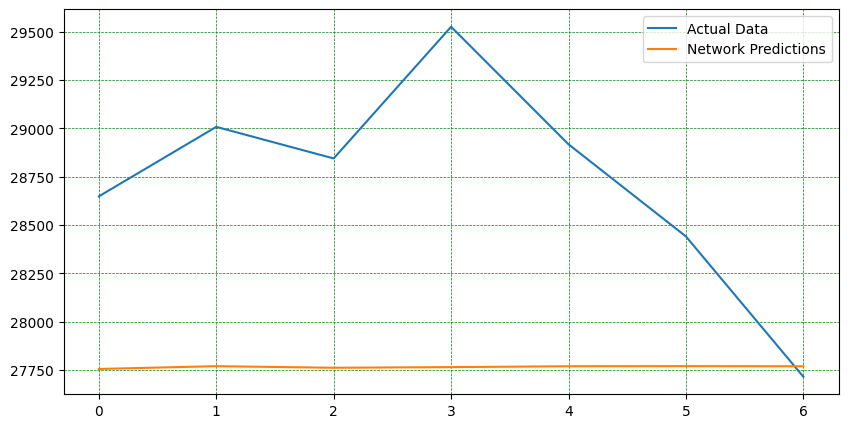

In [ ]:
plt.figure(figsize=(10,5)) #plotting
test_predict = myModel(DataX_test,DataC_test) # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = MMScaler_test.inverse_transform(test_predict)
test_predict = test_predict[-1].tolist()

test_target = Datay_test.detach().cpu().numpy() # last sample again
test_target = MMScaler_test.inverse_transform(test_target[-1].flatten().reshape(1, -1))
test_target = test_target[0].tolist()
# plt.xticks(range(0, 14,1))
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="Network Predictions")
plt.legend()
# plt.savefig("small_plot.png", dpi=300)
plt.show();


In [ ]:
# 2023/4/1 to 2023/05/10 get data



In [ ]:
# !pip install pytorch-model-summary 
# import pytorch_model_summary as pms
# pms.summary(myModel, torch.zeros(X.shape[0], 30, X.shape[1]).to(device),torch.zeros(X.shape[0], 30, X.shape[1]).to(device), show_input=True, print_summary=True)